In [2]:
!pip install nonconformist

  Preparing metadata (setup.py) ... done
  Created wheel for nonconformist: filename=nonconformist-2.1.0-py3-none-any.whl size=17818 sha256=8a936ebff19c2d6216b28f9ed94fbd5c56f58da17232e29b1b9fa1e256beeec4
  Stored in directory: /root/.cache/pip/wheels/50/0c/42/7f1bdc102730e363402b4414413de01d69d9f54c7df9578e32
Successfully built nonconformist


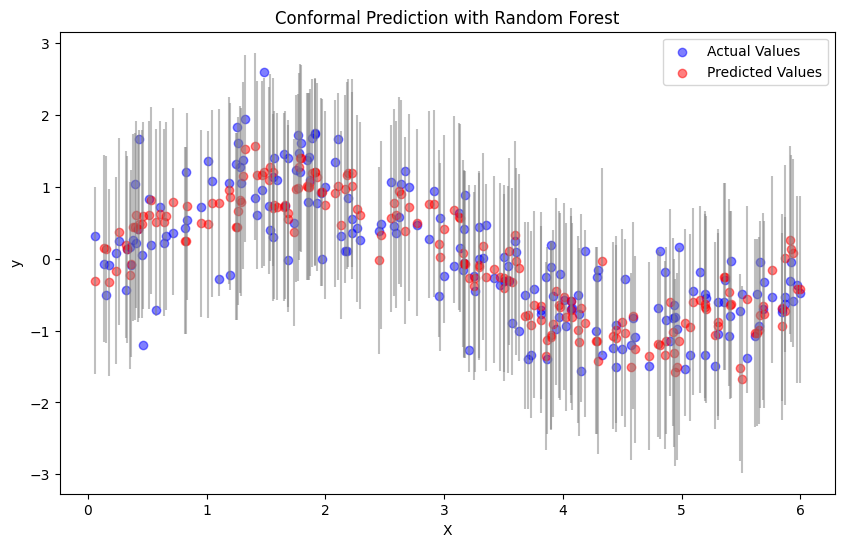

R2: 0.5719954751937371, RMSE: 0.5723182753146826, Coverage: 0.97, Average Width: 2.602318962202452


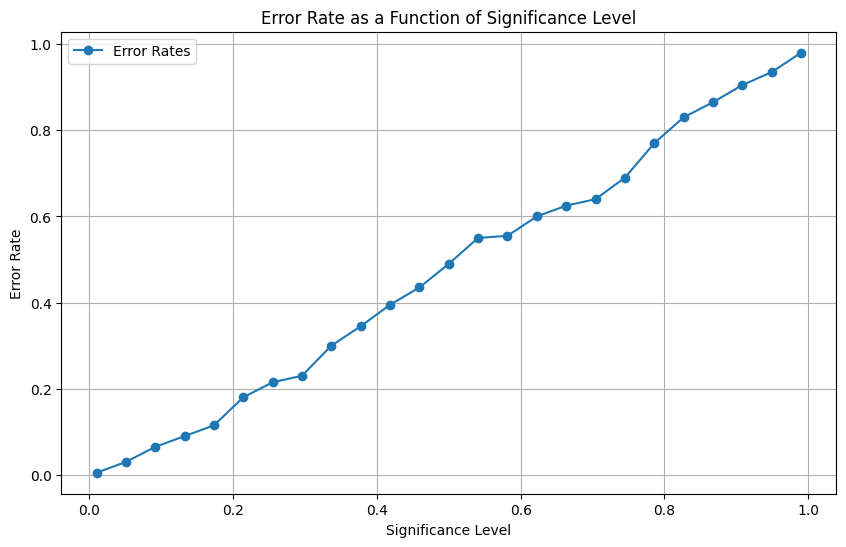

In [44]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
from nonconformist.icp import IcpRegressor
from nonconformist.nc import RegressorNc, AbsErrorErrFunc

def generate_datasets(dataset_name='sinusoidal', n_samples=1000, noise=0.5):
    if dataset_name == 'sinusoidal':
        X = np.linspace(0, 6, n_samples).reshape(-1, 1)
        y = np.sin(X).ravel() + np.random.normal(0, noise, n_samples)
    elif dataset_name == 'iris':
        iris = load_iris()
        X, y = iris.data, iris.data[:, 0]  # Using sepal length as the target
    else:
        raise ValueError("Unsupported dataset. Choose 'sinusoidal' or 'iris'.")
    return train_test_split(X, y, test_size=0.2, random_state=42)

def conformal_prediction_intervals(X_train, y_train, X_cal, y_cal, X_test, significance=0.05):
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    nc = RegressorNc(model, AbsErrorErrFunc())
    icp = IcpRegressor(nc)
    icp.fit(X_train, y_train)
    icp.calibrate(X_cal, y_cal)
    intervals = icp.predict(X_test, significance=significance)
    # Adjusting the structure of returned intervals to match expected format
    return np.array(intervals).T  # Transpose to match [lower_bounds, upper_bounds] format

def plot_scatter_and_intervals(X_test, y_test, y_pred, intervals=None, title=""):
    plt.figure(figsize=(10, 6))
    X_test_flattened = X_test.ravel()
    plt.scatter(X_test_flattened, y_test, color='blue', label='Actual Values', alpha=0.5)
    plt.scatter(X_test_flattened, y_pred, color='red', label='Predicted Values', alpha=0.5)

    if intervals is not None:
        lower_bounds, upper_bounds = intervals
        for i in range(len(X_test_flattened)):
            plt.vlines(X_test_flattened[i], lower_bounds[i], upper_bounds[i], colors='gray', alpha=0.5)

    plt.xlabel('X')
    plt.ylabel('y')
    plt.title(title)
    plt.legend()
    plt.show()

def calculate_metrics(y_true, y_pred, intervals=None):
    r2 = r2_score(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    coverage, average_width = None, None

    if intervals is not None:
        lower_bounds, upper_bounds = intervals
        in_interval = (y_true >= lower_bounds) & (y_true <= upper_bounds)
        coverage = np.mean(in_interval)
        average_width = np.mean(upper_bounds - lower_bounds)

    return r2, rmse, coverage, average_width

def get_rf_intervals(rf, X, significance=0.95):
    lower_percentile = (1 - significance) / 2.0 * 100
    upper_percentile = 100 - lower_percentile

    preds = np.stack([tree.predict(X) for tree in rf.estimators_], axis=0)

    lower = np.percentile(preds, lower_percentile, axis=0)
    upper = np.percentile(preds, upper_percentile, axis=0)

    return lower, upper  # Ensure this matches the expected structure

def calculate_error_rates(rf, y_true, X, X_train=None, y_train=None, X_cal=None, y_cal=None, intervals_func=None):
    significance_levels = np.linspace(0.01, 0.99, 25)
    error_rates = []

    for significance in significance_levels:
        if intervals_func.__name__ == "conformal_prediction_intervals":
            intervals = intervals_func(X_train, y_train, X_cal, y_cal, X, significance)
        else:
            intervals = get_rf_intervals(rf, X, significance=significance)

        lower_bounds, upper_bounds = intervals
        errors = (y_true < lower_bounds) | (y_true > upper_bounds)
        error_rate = np.mean(errors)
        error_rates.append(error_rate)

    return significance_levels, error_rates

def plot_error_rates(y_test, X_test, rf, X_train, y_train, X_cal, y_cal, intervals_func):
    plt.figure(figsize=(10, 6))

    sig_levels, error_rates = calculate_error_rates(rf, y_test, X_test, X_train, y_train, X_cal, y_cal, intervals_func=intervals_func)
    plt.plot(sig_levels, error_rates, label='Error Rates', marker='o')

    plt.xlabel('Significance Level')
    plt.ylabel('Error Rate')
    plt.title('Error Rate as a Function of Significance Level')
    plt.legend()
    plt.grid(True)
    plt.show()

def main(dataset_name='sinusoidal', use_conformal_prediction=False):
    X_train, X_test, y_train, y_test = generate_datasets(dataset_name=dataset_name)
    X_train, X_cal, y_train, y_cal = train_test_split(X_train, y_train, test_size=0.5, random_state=42) if use_conformal_prediction else (X_train, None, y_train, None)

    rf = RandomForestRegressor(n_estimators=100, random_state=42).fit(X_train, y_train)
    y_pred = rf.predict(X_test)

    if use_conformal_prediction:
        intervals = conformal_prediction_intervals(X_train, y_train, X_cal, y_cal, X_test, significance=0.05)
        title = "Conformal Prediction with Random Forest"
    else:
        intervals = get_rf_intervals(rf, X_test, significance=0.95)
        title = "Random Forest Regression with Prediction Intervals"

    plot_scatter_and_intervals(X_test, y_test, y_pred, intervals, title=title)
    metrics = calculate_metrics(y_test, y_pred, intervals)
    print(f"R2: {metrics[0]}, RMSE: {metrics[1]}, Coverage: {metrics[2]}, Average Width: {metrics[3]}")

    #plot error rates
    plot_error_rates(y_test, X_test, rf, X_train, y_train, X_cal, y_cal, intervals_func=conformal_prediction_intervals if use_conformal_prediction else get_rf_intervals)

# Example usage
main(dataset_name='sinusoidal', use_conformal_prediction=True)
